<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/UMAP%2BClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMAP + Clustering on Raw Data vs LSTM's Hidden Representations
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

import seaborn as sns 
sns.set_theme()

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []

for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

Text(0, 0.5, 'Firing Rate')

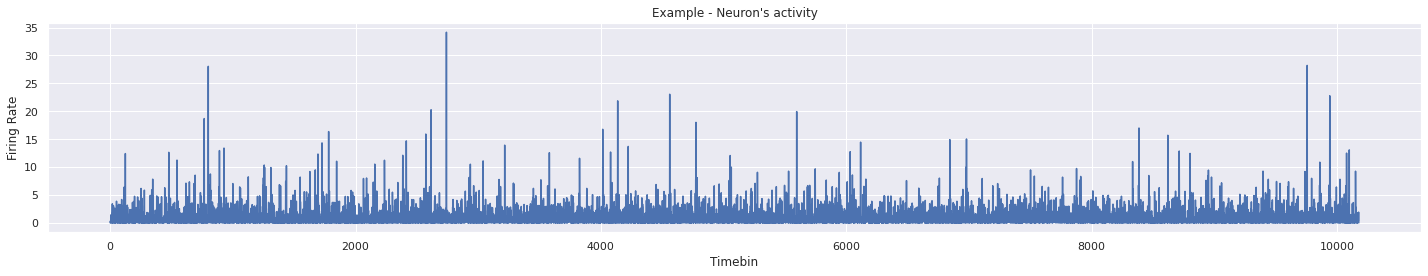

In [10]:
plt.plot(dataRNN[:,0])
plt.title("Example - Neuron's activity")
plt.xlabel("Timebin")
plt.ylabel("Firing Rate")

In [ ]:
# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

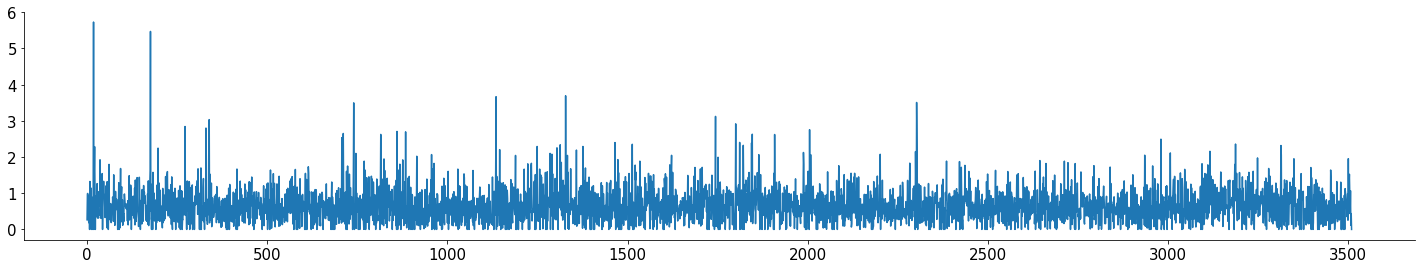

In [ ]:
plt.plot(avgd_normed_dataRNN[0,:]);

##  UMAP Visualization (Semi-Supervised) on Raw Data
The result is not encouraging, let's see if the RNN has captured some meaningful dynamics and UMAP can extract it in 2D.

In [ ]:
!pip3 install umap-learn hdbscan --quiet

     |████████████████████████████████| 80 kB 3.4 MB/s 
     |████████████████████████████████| 6.4 MB 21.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 38.3 MB/s 


In [ ]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split

In [ ]:
b = np.ones(1131)
labels = np.hstack((0*b,b, 2*b, 3*b,4*b, 5*b, 6*b, 7*b, 8*b))

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(avgd_normed_dataRNN, labels, test_size = 0.10, random_state = 2021)

In [ ]:
X_train.shape

(9161, 3510)

In [ ]:
# UMAP embedding on raw data - here we learn the metric space 
emb = umap.UMAP(random_state = 2021, n_components=2, n_neighbors= 45, min_dist = 0.3).fit(X_train, y = y_train)

In [ ]:
test_embedding = emb.transform(X_test)

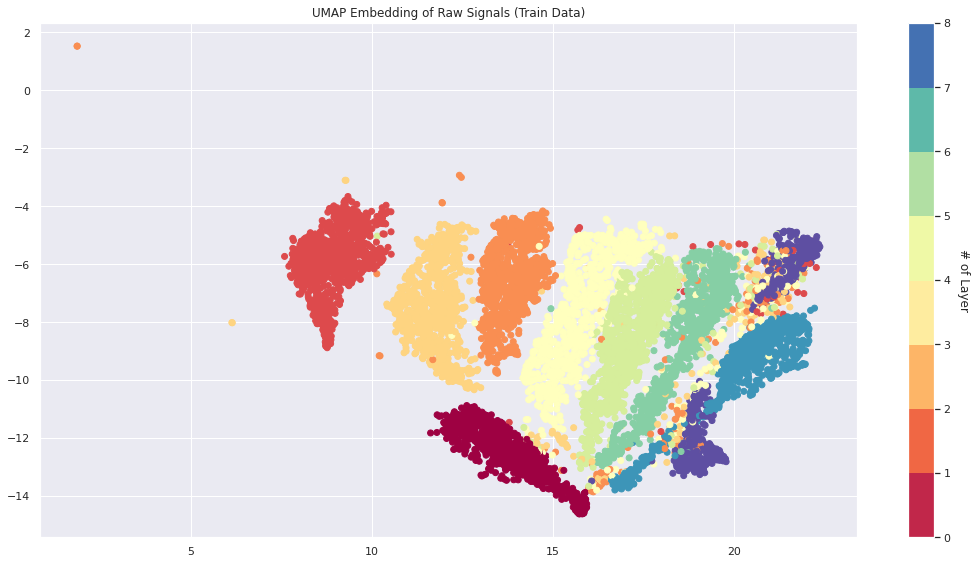

In [ ]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*emb.embedding_.T,  c = y_train ,cmap = 'Spectral')
plt.title("UMAP Embedding of Raw Signals (Train Data)")
cbar = plt.colorbar(boundaries=np.arange(9))
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('# of Layer', rotation=270)
plt.savefig("UMAP_TRAIN_RAW_DATA_EMB.png", dpi = 600)

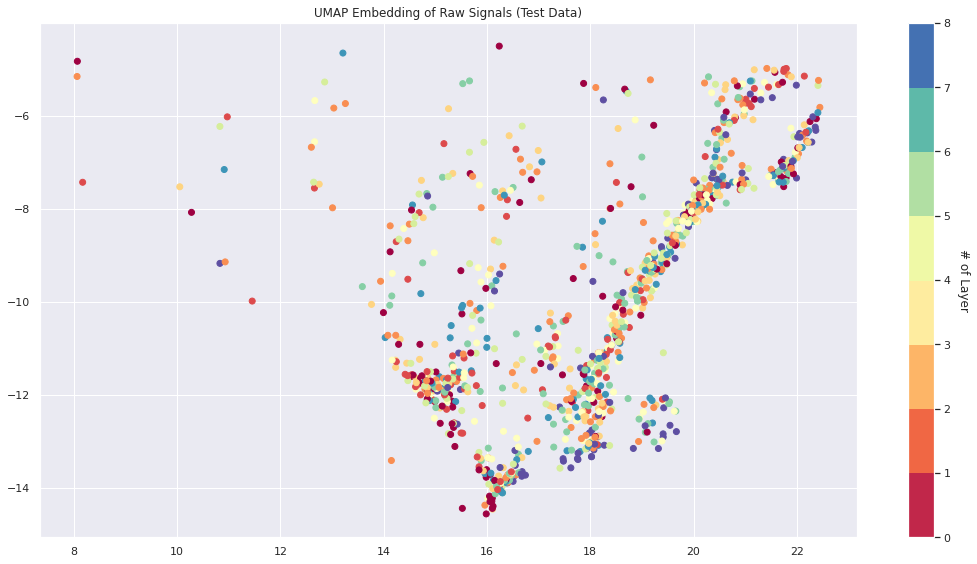

In [ ]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*test_embedding.T,  c = y_test ,cmap = 'Spectral')
plt.title("UMAP Embedding of Raw Signals (Test Data)")
cbar = plt.colorbar(boundaries=np.arange(9))
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('# of Layer', rotation=270)
plt.savefig("UMAP_TEST_RAW_DATA_EMB.png", dpi = 600)

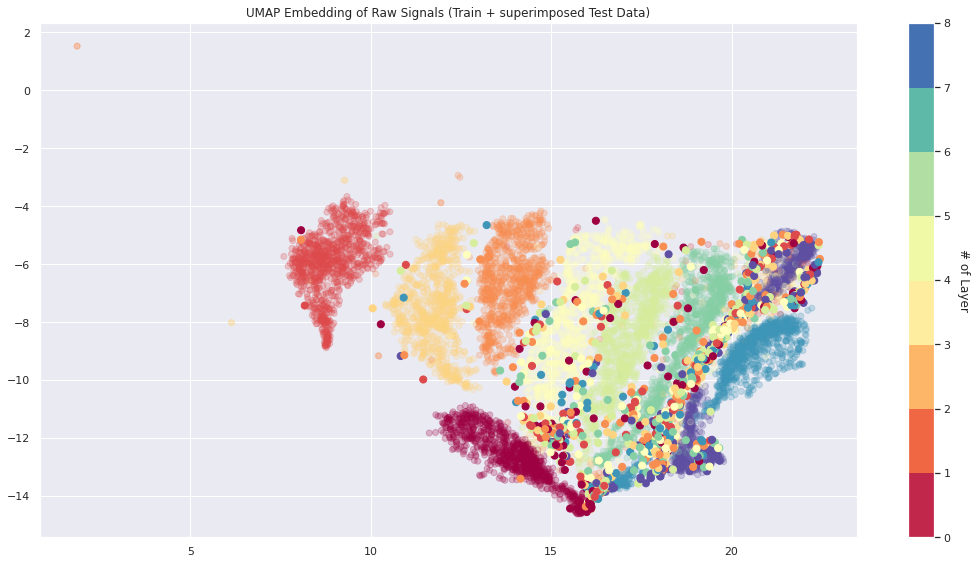

In [ ]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*emb.embedding_.T,  c = y_train ,cmap = 'Spectral', alpha = 0.25)
plt.scatter(*test_embedding.T,  s = 50, c = y_test ,cmap = 'Spectral')
plt.title("UMAP Embedding of Raw Signals (Train + superimposed Test Data)")
cbar = plt.colorbar(boundaries=np.arange(9))
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('# of Layer', rotation=270)
plt.savefig("UMAP_TRAIN+TEST_RAW_DATA_EMB.png", dpi = 600)

## UMAP on RNN's Reduced dynamics

### Extract Dynamics


In [ ]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [ ]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [ ]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples, dataSet.shape[1]-1, 9))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[:, :, i] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)


In [ ]:
# functions 

def moving_avg(array, factor = 2):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    #zeros_ = np.zeros((array.shape[0], 2))
    #array = np.hstack((array, zeros_))
    
    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor, array.shape[2]))
    array = np.mean(array, axis = 2)

    return array

In [ ]:
# downsampling and averaging 
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)  # should be 1.9.0 for training (Mish Activation)

1.9.0+cu102


In [ ]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [ ]:
frac = 4/5
#n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = 75 #int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]), : ]).to(device).float()
x2_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]),: ]).to(device).float()

#x1_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :] ).to(device).float()
#x2_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :]).to(device).float()

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [ ]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.3,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [ ]:
# we initialize the neural network
#net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
# optimizer1 = torch.optim.Adam(net.parameters(), lr= 0.0003795, weight_decay= 10e-6)

# forward check 
# net(x1)
#net(x1_train)

In [ ]:
"""
from tqdm.notebook import tqdm
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.000974, weight_decay = 0.00001)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

train_save = []
valid_save = []

niter = 50000 #+30000 # 
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    
    # this can be run in a first phase, before wandb finetuning
    with torch.no_grad():
        net.eval()
        train_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')


###Saving the net state dict 
torch.save(net.state_dict(), "Net_Complete.pt")
np.save("train_curve.npy", np.asarray(train_save))
np.save("valid_curve.npy", np.asarray(valid_save))
""";

In [ ]:
#Load the model back 😂 (it took one day to understand how to do it!)
model = Net(ncomp, NN1, NN2, bidi = True).to(device)
model.load_state_dict(torch.load("/content/Net_Complete.pt"))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [ ]:
x1 = torch.from_numpy(avgd_normed_dataRNN[:,:, : ]).to(device).float()

In [ ]:
latent_emb = model(x1)[1]
latent_emb = latent_emb.permute(1, 2, 0)
latent_emb = latent_emb.reshape((9*75, 3509))
latent_emb = latent_emb.detach().cpu().numpy()
latent_emb.shape

(675, 3509)

In [ ]:
b = np.ones(75)
labels = np.hstack((0*b,b, 2*b, 3*b,4*b, 5*b, 6*b, 7*b, 8*b))

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(latent_emb, labels, test_size = 0.25, random_state = 2021)

In [ ]:
rnn_emb = umap.UMAP(random_state = 2021, n_components=2, n_neighbors= 60, min_dist = 0.1).fit(X_train, y = y_train)

In [ ]:
test_rnn_embedding = rnn_emb.transform(X_test)

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 8))
plt.scatter(*rnn_emb.embedding_.T,  c = y_train ,cmap = 'Spectral')
plt.setp(ax, xticks=[], yticks=[])
plt.title("UMAP Embedding of Latent Dynamics (Train Data)")
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('# of Layer', rotation=270)
#plt.savefig("UMAP_TRAIN+TEST_RAW_DATA_EMB.png", dpi = 600)

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')

plt.scatter(*test_rnn_embedding.T,  c = y_test ,cmap = 'Spectral')
plt.title("UMAP Embedding of Latent Dynamics( Test Data)")
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('# of Layer', rotation=270)
#plt.savefig("UMAP_TRAIN+TEST_RAW_DATA_EMB.png", dpi = 600)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color);

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')

plt.scatter(*rnn_emb.embedding_.T,  c = y_train ,cmap = 'Spectral', alpha = 0.25)
plt.scatter(*test_rnn_embedding.T,  s = 10, c = y_test ,cmap = 'Spectral')
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color);

### LSTM Learning Curves 

In [ ]:
train_curve = np.load("/content/train_curve.npy")
valid_curve = np.load("/content/valid_curve.npy")

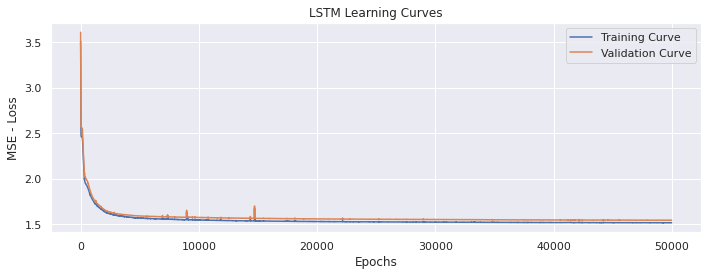

In [ ]:

fig, ax = plt.subplots(1, figsize = (10, 4))
ax.plot(train_curve, label = "Training Curve")
ax.plot(valid_curve, label = "Validation Curve")
ax.legend()
ax.set_title("LSTM Learning Curves")
ax.set_ylabel("MSE - Loss")
ax.set_xlabel("Epochs")
#fig.savefig("LSTM_Learning_Curves.png", dpi = 600)